In [1]:
# NOTEBOOK IMPORTS
import os
import glob
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile
from datetime import datetime

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona
import pyproj
from affine import Affine
from shapely.geometry import shape, mapping
from shapely.geometry import Point, LineString
from shapely.ops import transform, nearest_points, snap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *

Image.MAX_IMAGE_PIXELS = 933120000

In [3]:
templates_dir = "data/templates/"
tempfiles_dir = "tempfiles/findcorners/"

boundary_shapefile = f"{templates_dir}HCAD_Harris_County_Boundary.shp"
boundary_points    = f'{tempfiles_dir}boundary_points.shp'
roads_points       = f'{tempfiles_dir}roads_points.shp'

tile_file = f"data/TileIndices/48201CIND0_0992.tif"

roads_fn = f"data/Roads/TexasHighways.shp"
selected_transform = f"{tempfiles_dir}SelectedTransform.png"

In [6]:
image = cv2.imread(selected_transform, cv2.IMREAD_GRAYSCALE)

def preprocess(image, radius=5, threshold_value=150):
    
    # 0 TO 255
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (radius, radius), 0)
    # Threshold the image
    # _, thresholded_image = cv2.threshold(blurred_image, threshold_value, 255, cv2.THRESH_BINARY)
    thresholded_image = cv2.adaptiveThreshold(blurred_image, 255,
                                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                              cv2.THRESH_BINARY,
                                              31,
                                              2)
    
    # EDGES
    edges = cv2.Canny(thresholded_image, 5, 10);
    
    return edges, thresholded_image, blurred_image

edges, prepped_image, blurred = preprocess(image)

inverted_edges = 255 - edges

cv2.imwrite(f"{tempfiles_dir}edges.png", edges)
cv2.imwrite(f"{tempfiles_dir}prepped_image.png", prepped_image)
cv2.imwrite(f"{tempfiles_dir}blurred.png", blurred)
cv2.imwrite(f"{tempfiles_dir}inverted_edges.png", inverted_edges)

True

In [106]:
def getKernel_L(kernel_size):
    # Create the L-shaped kernel
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    kernel[-1, :] = 255
    kernel[:, 0] = 255
    
    return kernel
def getKernel_T(kernel_size):
    # Create the L-shaped kernel
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    kernel[kernel_size//2, :] = 1
    kernel[:, kernel_size//2] = 1
    
    return kernel

def getKernel_horizontal(kernel_size):
    # Create the L-shaped kernel
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    kernel[kernel_size//2 + 1, :] = 1
    return kernel

def pattern_matching(image, template):
    # Perform template matching using normalized cross-correlation
    n = template.shape[0] // 2
    image = cv2.copyMakeBorder(image,n,n,n,n, cv2.BORDER_CONSTANT, 0)
    result = cv2.matchTemplate(image.astype(np.uint8), template.astype(np.uint8), cv2.TM_SQDIFF)
    return result

test = pattern_matching(blurred, getKernel_horizontal(101),)

# test_n = cv2.normalize(test, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#test1 = cv2.adaptiveThreshold(test_n, 255,cv2.ADAPTIVE_THRESH_MEAN_C, 
#                                          cv2.THRESH_BINARY_INV,
#                                          31,
#                                          2)

test_n = np.where(test < 2e8, 1, 0 )

cv2.imwrite(f"{tempfiles_dir}LCONV.png", cv2.normalize(test, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
cv2.imwrite(f"{tempfiles_dir}LCONV_norm.png", test_n * 255)
cv2.imwrite(f"{tempfiles_dir}LCONV_filter.png", test_n * (255 - image))

True

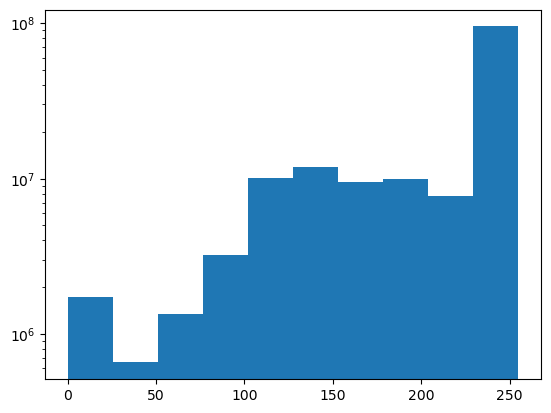

In [110]:
plt.hist(test.flatten())
plt.yscale("log")

In [142]:
def extract_horizontal_lines(image):
    # Define the horizontal line kernel
    kernel = getKernel_horizontal(1001)
    # Normalize the kernel
    kernel /= np.sum(kernel)

    # Perform the convolution
    result = cv2.filter2D(image, -1, kernel)

    return result

def extract_vertical_lines(image):
    # Define the horizontal line kernel
    kernel = getKernel_horizontal(1001).T
    # Normalize the kernel
    kernel /= np.sum(kernel)

    # Perform the convolution
    result = cv2.filter2D(image, -1, kernel)

    return result

hor = extract_horizontal_lines(prepped_image)
hor = np.where(hor < 255*0.5, 255, 0)

ver = extract_vertical_lines(prepped_image)
ver = np.where(ver < 255*0.5, 255, 0)



cv2.imwrite(f"{tempfiles_dir}horizontal_lines.png", hor)
cv2.imwrite(f"{tempfiles_dir}vertical_lines.png", ver)

True

In [143]:
lines = np.logical_or(ver, hor)
lines = np.where(lines, 255, 0)
cv2.imwrite(f"{tempfiles_dir}lines.png",lines)

True

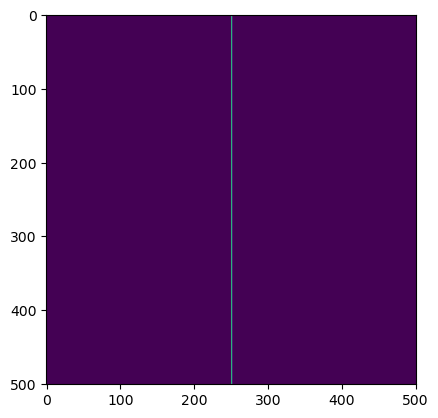

In [121]:
plt.imshow(getKernel_horizontal(501).T)

In [41]:
contours, _ = cv2.findContours(prepped_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [contour for contour in contours if contour.shape[0] == 4]

contour_image = cv2.drawContours(np.zeros_like(prepped_image), filtered_contours, -1, 255)

cv2.imwrite(f"{tempfiles_dir}FindContours.png", contour_image)

True

In [42]:
filtered_contours

[array([[[13860, 10175]],
 
        [[13861, 10174]],
 
        [[13862, 10175]],
 
        [[13861, 10176]]], dtype=int32),
 array([[[13832, 10172]],
 
        [[13833, 10173]],
 
        [[13833, 10174]],
 
        [[13834, 10174]]], dtype=int32),
 array([[[13866, 10171]],
 
        [[13867, 10170]],
 
        [[13868, 10171]],
 
        [[13867, 10172]]], dtype=int32),
 array([[[13869, 10170]],
 
        [[13870, 10169]],
 
        [[13871, 10170]],
 
        [[13870, 10171]]], dtype=int32),
 array([[[13868, 10169]],
 
        [[13869, 10168]],
 
        [[13870, 10169]],
 
        [[13869, 10170]]], dtype=int32),
 array([[[13866, 10169]],
 
        [[13867, 10168]],
 
        [[13868, 10169]],
 
        [[13867, 10170]]], dtype=int32),
 array([[[13865, 10168]],
 
        [[13866, 10167]],
 
        [[13867, 10168]],
 
        [[13866, 10169]]], dtype=int32),
 array([[[13859, 10168]],
 
        [[13860, 10167]],
 
        [[13861, 10168]],
 
        [[13860, 10169]]], dtype=int32),


In [ ]:
rho = 10  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 100  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 2000  # minimum number of pixels making up a line
max_line_gap = 100  # maximum gap in pixels between connectable line segments
line_image = np.copy(thresholded_image) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(thresholded_image, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

print(len(lines))

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),255,5)
        
cv2.imwrite(f"{tempfiles_dir}HoughLines.png", line_image)

In [29]:
gray = np.float32(blurred)
dst = cv2.cornerHarris(gray,2,3,0.04)

In [30]:
cv2.imwrite(f"{tempfiles_dir}HarrisCorners.png", dst, )

True

In [52]:
lsd = cv2.LineSegmentDetector('Refine','None');
lines = lsd.detect(test)

error: Unknown C++ exception from OpenCV code

In [32]:
# Apply adaptive thresholding to obtain binary image
# _, thresh = cv2.threshold(test, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours in the binary image


In [20]:
len(contour)

164764

In [44]:
# 

True

In [12]:
contours, a = cv2.findContours(test, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
